The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
sys_path =  ['c:\\Users\\25460\\anaconda3\\envs\\pytorch\\python39.zip', 'c:\\Users\\25460\\anaconda3\\envs\\pytorch\\DLLs', 'c:\\Users\\25460\\anaconda3\\envs\\pytorch\\lib', 'c:\\Users\\25460\\anaconda3\\envs\\pytorch', '', 'c:\\Users\\25460\\anaconda3\\envs\\pytorch\\lib\\site-packages', 'c:\\Users\\25460\\anaconda3\\envs\\pytorch\\lib\\site-packages\\win32', 'c:\\Users\\25460\\anaconda3\\envs\\pytorch\\lib\\site-packages\\win32\\lib', 'c:\\Users\\25460\\anaconda3\\envs\\pytorch\\lib\\site-packages\\Pythonwin', 'D:\\OneDrive\\SUSTech\\MetaSurface_Lab\\Python Project\\D2NN_Simulation_COOPER\\Main_Model', 'D:\\OneDrive\\SUSTech\\MetaSurface_Lab\\Python Project\\D2NN_Simulation_COOPER\\Main_Model', 'D:\\OneDrive\\SUSTech\\MetaSurface_Lab\\Python Project\\D2NN_Simulation_COOPER\\Main_Model', 'D:\\OneDrive\\SUSTech\\MetaSurface_Lab\\Python Project\\D2NN_Simulation_COOPER\\Main_Model', 'D:\\OneDrive\\S

array([ 2,  6, 10, 14, 18])

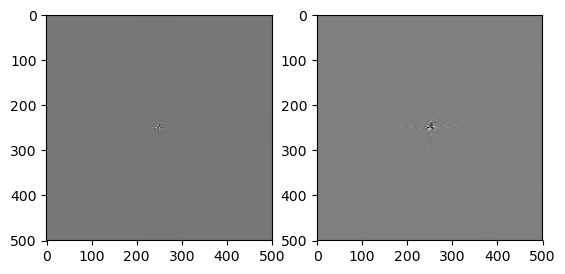

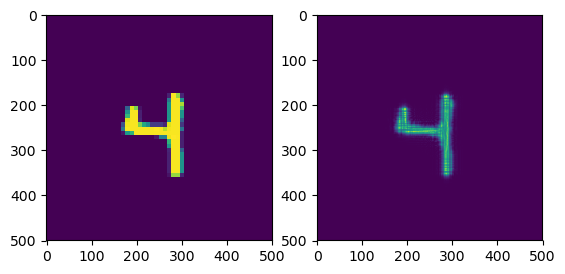

In [9]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("D:\\OneDrive\\SUSTech\\MetaSurface_Lab\\Python Project\\D2NN_Simulation_COOPER\\Main_Model") 
print("sys_path = ",sys.path)
import Main_Model.model_define as modef

z = 0.05

def forward(u, test=False):
    if test: # 画一下光场分布图, 方便调试
        print("propagation")
        # plt.figure()
        # plt.imshow((torch.abs(u)**2).detach().cpu().numpy()[0,:,:])
        # plt.show()

    M, N = u.shape[-2:] # [-2:] means the last two dimensions! (pattern 数量, 长, 宽)
    dx = modef.L / M # sample interval, 划分的像素大小!
    k = 2 * np.pi / modef.lmbda # angular wavenumber

    fx = torch.linspace(-1 / (2 * dx), 1 / (2 * dx) - 1 / modef.L, M, device=u.device, dtype=u.dtype)
    # 定义了空间频率坐标系, 上下限是离散情况下可以分辨的最大空间频率! 单位是 1/m (如果L的单位是m的话)
    # 数学上可以得到, 频域的分辨率和原始图像的实空间分辨率是一样的, 所以 也取了M个点
    # 减去 1/L 可能是为了让 fx 中全是整数, 并且可以存在 0 频率, 不然全是恶心的小数

    FX, FY = torch.meshgrid(fx, fx, indexing='ij') # x and y coordinate of every point in the canvas
    
    # Transfer function of free space
    H = torch.exp(torch.tensor(1j) * k * z * torch.sqrt(1-(modef.lmbda*FX)**2 - (modef.lmbda*FY)**2))
    # H = torch.fft.fftshift(H, dim=(-2,-1))
    U1 = torch.fft.fftshift(torch.fft.fft2(u, dim=(-2,-1)))
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(U1.real.cpu()[0,:,:], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(U1.imag.cpu()[0,:,:], cmap='gray')
    # print('U1.shape = ', U1.shape, 'H.shape = ', H.shape)
    U2 = H * U1
    u2 = torch.fft.ifft2(torch.fft.ifftshift(U2), dim=(-2,-1))

    return u2


data_fashion = ['FASHION','fashion'] 
data_mnist = ['MNIST','mnist']
dataset_name = data_mnist

data_dir = 'dataset/'+dataset_name[0]+'_processed_0_5/u0_validation'
data_file = 'u0_validation_'
idx = 686
dataaa = torch.tensor(np.load(data_dir + "/" + data_file + "%d.npy"%idx, allow_pickle=True)).double().to(modef.device)
dataaa = dataaa.reshape(1, 500, 500)

output = torch.abs(forward(dataaa))**2

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(np.load(data_dir + "/" + data_file + "%d.npy"%idx, allow_pickle=True))
plt.subplot(1, 2, 2)
plt.imshow(output.detach().cpu().numpy()[0,:,:])

np.array([1,2,3,4,5])*4-2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


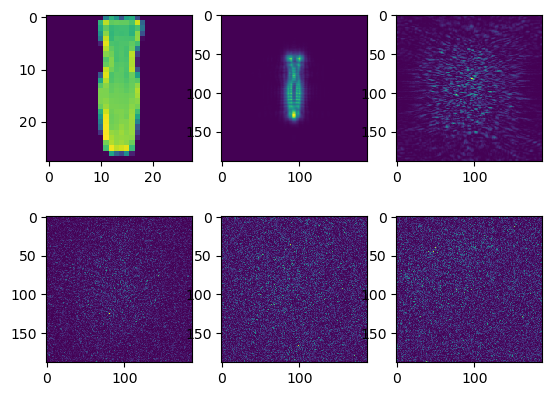

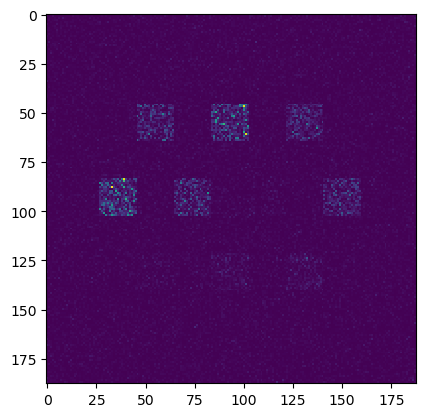

Label of  59  is  3 
Predicted label is  3


In [46]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import torch
import numpy as np

import sys
sys.path.append("D:\\OneDrive\\SUSTech\MetaSurface_Lab\\Python Project\\D2NN_Simulation_COOPER\\Main_Model") 
# print("sys_path = ",sys.path)
import Main_Model.model_define as modef
import Main_Model.load_data as ld
import Main_Model.dataset_prepro_inline as dpi

idx = 59

label, data = ld.FASHION_train_dataset.__getitem__(idx)
data = data.reshape(1,data.shape[0],data.shape[1])

# 测试所保存的模型
m_state_dict = torch.load('Main_Model\\Result_and_post_process\\BD2NN_z_0.03_L_0.08_PSC_1_mesh_188_SW_0.8_SN_100_SS_19_Norm_MAX_ZC_0.5_LT_Cross_OT_Clps.pt')
D2NN = modef.OpticalNetwork(L=modef.L, lmbda=modef.lmbda, z=modef.z).to(modef.device)
D2NN.load_state_dict(m_state_dict)
D2NN.eval()

plt.figure()
plt.subplot(2,3,1)
plt.imshow(data[0,:,:].cpu().numpy())
with torch.no_grad():
    _, predicted_label = D2NN(dpi.batch_u0_modify(data), test=True, inverse=False)


print("Label of ",idx," is ",label.item(), "\nPredicted label is ",predicted_label.item())
# print(D2NN)

# plt.figure()
# plt.subplot(4, 2, 1)
# plt.imshow(np.load(data_dir + "/" + data_file + "%d.npy"%idx, allow_pickle=True))
# plt.subplot(4, 2, 2)
# plt.imshoworigin_data[idx,:,:]
# plt.subplot(4, 2, 3)
# plt.imshow(np.load(data_dir + "/" + data_file + "%d.npy"%(idx+1), allow_pickle=True))
# plt.subplot(4, 2, 4)
# plt.imshoworigin_data[idx+1,:,:]
# plt.subplot(4, 2, 5)
# plt.imshow(np.load(data_dir + "/" + data_file + "%d.npy"%(idx+2), allow_pickle=True))
# plt.subplot(4, 2, 6)
# plt.imshoworigin_data[idx+2,:,:]
# plt.subplot(4, 2, 7)
# plt.imshow(np.load(data_dir + "/" + data_file + "%d.npy"%(idx+3), allow_pickle=True))
# plt.subplot(4, 2, 8)
# plt.imshoworigin_data[idx+3,:,:]

500


(<matplotlib.image.AxesImage at 0x2969ec859d0>, 500)

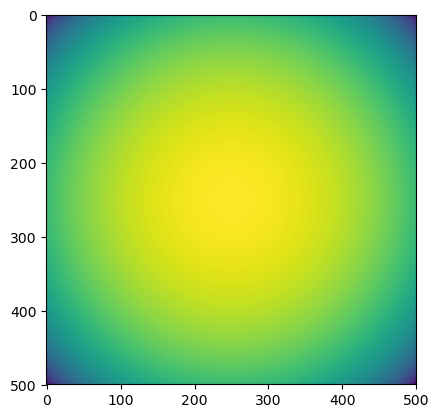

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# def pytorch_params(pth_file):
#     par_dict = torch.load(pth_file, map_location='cpu')
#     print(par_dict.keys())
#     for name in par_dict:
#         parameter = par_dict[name]
#         print(name, parameter.numpy().shape)

# pytorch_params('Main_Model/Result_and_post_process/BD2NN_mnist_0_5_fashion_0_5.pt')


unit = 1

origin_size = 250     # number of pixels on each axis, related to the fabrication resolution of phase masks
zooming_coe = 2
mesh_num = origin_size*zooming_coe # number of meshgrid used for simulation, related to simulation precision
lmbda = 6e-4*unit  # 600um, wavelength of coherent light
z = 10*unit      # 1cm,  the propagation distance in free space
j = torch.tensor([0+1j], dtype=torch.complex128)
L = 0.213*unit         # 20cm, the side length of phase masks

mesh_num = int(1.41*L/lmbda)

print(mesh_num)

k = 2 * np.pi / lmbda # angular wavenumber

dx = L / mesh_num # sample interval, 划分的像素大小!

fx = torch.linspace(-1 / (2 * dx), 1 / (2 * dx) - 1 / L, mesh_num)
# 定义了空间频率坐标系, 上下限是离散情况下可以分辨的最大空间频率! 单位是 1/m (如果L的单位是m的话)
# 数学上可以得到, 频域的分辨率和原始图像的实空间分辨率是一样的, 所以 也取了M个点
# 减去 1/L 可能是为了让 fx 中全是整数, 并且可以存在 0 频率, 不然全是恶心的小数

FX, FY = torch.meshgrid(fx, fx, indexing='ij') # x and y coordinate of every point in the canvas
H = torch.exp(torch.tensor(1j) * k * z * torch.sqrt(1-(lmbda*FX)**2 - (lmbda*FY)**2))

plt.figure()
plt.imshow(torch.sqrt(1-(lmbda*FX)**2-(lmbda*FY)**2)),mesh_num

In [54]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import glob

parent_dir = 'Main_Model\\Result_and_post_process\\'
model_name_list = glob.glob(parent_dir+'BD2NN*.pt')
for idx in range(len(model_name_list)):
    model_name_list[idx] = model_name_list[idx][len(parent_dir):-3]


for idx in range(len(model_name_list)):
    _,_,z,_,L,_,PSC,_,mesh,_,SW,_,SN,_,SS,_,Norm,_,ZC,_,LT,_,OT = model_name_list[idx].split('_', maxsplit=-1)
    print("z = ",z, "L = ",L, "PSC = ",PSC, "mesh = ",mesh, "SW = ",SW, "SN = ",SN, "SS = ",SS, "Norm = ",Norm, "ZC = ",ZC, "LT = ",LT, "OT = ",OT)

z.

z =  0.03 L =  0.08 PSC =  1 mesh =  188 SW =  0.8 SN =  100 SS =  19 Norm =  MAX ZC =  0.5 LT =  Cross OT =  Clps
z =  0.03 L =  0.08 PSC =  1 mesh =  188 SW =  0.8 SN =  100 SS =  9 Norm =  MAX ZC =  0.5 LT =  Cross OT =  Clps
z =  0.03 L =  0.08 PSC =  1 mesh =  188 SW =  0.8 SN =  100 SS =  9 Norm =  MAX ZC =  0.5 LT =  Cross OT =  Full
z =  0.03 L =  0.08 PSC =  1 mesh =  188 SW =  1 SN =  100 SS =  19 Norm =  L2 ZC =  0.5 LT =  Cross OT =  Full
z =  0.03 L =  0.08 PSC =  1 mesh =  188 SW =  1 SN =  100 SS =  9 Norm =  L2 ZC =  0.5 LT =  Cross OT =  Full
z =  0.03 L =  0.08 PSC =  1 mesh =  188 SW =  1 SN =  100 SS =  9 Norm =  L2 ZC =  0.5 LT =  Cross OT =  Full
z =  0.03 L =  0.12 PSC =  1 mesh =  282 SW =  0.8 SN =  100 SS =  14 Norm =  MAX ZC =  0.5 LT =  Cross OT =  Full
z =  0.03 L =  0.12 PSC =  1 mesh =  282 SW =  1 SN =  100 SS =  14 Norm =  L2 ZC =  0.5 LT =  Cross OT =  Full
z =  0.03 L =  0.12 PSC =  1 mesh =  282 SW =  1 SN =  100 SS =  14 Norm =  MAX ZC =  0.5 LT =  

'0.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.030.03'